# COVID-19 Classification

This dataset contains X-ray scans from 3 classes: COVID-19, Viral Pneumonia, Normal. The problem we try to solve is to classify a given X-ray scan image into one of these three classes.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-03-05 23:32:38.246549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In the original dataset, the images have different dimensions. Thus, we standardize the training and testing samples by reshaping each to have dimensions (1000,1000).

In [2]:
LABELS = ['Normal', 'Covid', 'Viral Pneumonia']
CROP_HEIGHT = 1000
CROP_WIDTH = 1000

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/Covid19-dataset/train/',
    batch_size=1,
    image_size=(CROP_WIDTH, CROP_HEIGHT),
    label_mode='categorical',
    shuffle=True,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/Covid19-dataset/test/',
    batch_size=1,
    image_size=(CROP_WIDTH, CROP_HEIGHT),
    label_mode='categorical',
    shuffle=False,
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


2023-03-05 23:32:45.350118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[0. 1. 0.]]


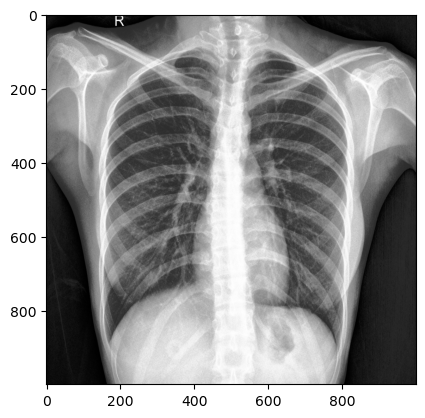

In [4]:
for image_raw, label in train_data.take(1):
    img = image_raw.numpy().astype(np.uint32)[0]
    plt.imshow(img)
    print(label.numpy())

## Model

We use a MobileNetV2 model architecture, a convolutional neural network which utilizes residual blocks and was designed for parameter efficiency, pretrained on the Imagenet dataset as a base model. We apply global average pooling to the last layer, and add a softmax layer with 3 nodes corresponding to the classes. During training, we freeze all weights except for this last layer. Since the number of training samples is low (on the order of hundreds), a model with many parameters has a greater potential of overfitting. By only training the final layer, we only have roughly 3.8K parameters to train versus 2.3M parameters in the entire model.

In [5]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

input_ = tf.keras.layers.Input(shape=(CROP_WIDTH, CROP_HEIGHT, 3))
x = base_model(input_, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
output = tf.keras.layers.Dense(len(LABELS), activation='softmax')(x)

model = tf.keras.Model(input_, output)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
hist = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
251/251 [==============================] - 144s 565ms/step - loss: 0.7929 - accuracy: 0.6454 - val_loss: 0.4831 - val_accuracy: 0.7879
Epoch 2/10
251/251 [==============================] - 130s 516ms/step - loss: 0.3986 - accuracy: 0.8606 - val_loss: 0.4693 - val_accuracy: 0.7879
Epoch 3/10
251/251 [==============================] - 133s 528ms/step - loss: 0.3083 - accuracy: 0.8924 - val_loss: 0.3169 - val_accuracy: 0.8939
Epoch 4/10
251/251 [==============================] - 130s 517ms/step - loss: 0.2326 - accuracy: 0.9522 - val_loss: 0.3503 - val_accuracy: 0.8939
Epoch 5/10
251/251 [==============================] - 128s 511ms/step - loss: 0.1973 - accuracy: 0.9442 - val_loss: 0.3689 - val_accuracy: 0.8333
Epoch 6/10
251/251 [==============================] - 124s 494ms/step - loss: 0.1694 - accuracy: 0.9562 - val_loss: 0.3048 - val_accuracy: 0.8636
Epoch 7/10
251/251 [==============================] - 122s 488ms/step - loss: 0.1387 - accuracy: 0.9721 - val_loss: 0.3263 -

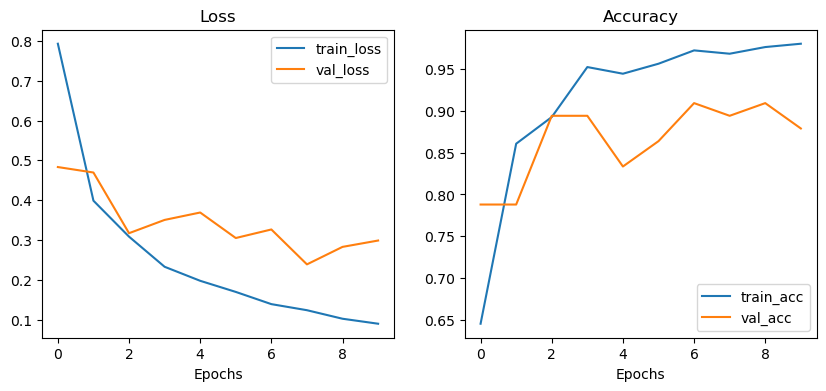

In [8]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

epochs = range(len(hist.history['loss']))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Results

In [9]:
test_predictions = model.predict(test_data)

66/66 [==============================] - 27s 399ms/step


In [10]:
test_predictions.argmax(axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0])

In [11]:
test_images = []
test_labels = []

for image, label in test_data:
    test_images.append(image.numpy()[0])
    test_labels.append(label.numpy().argmax())

We plot some examples of images along with the predicted and true labels (below). 

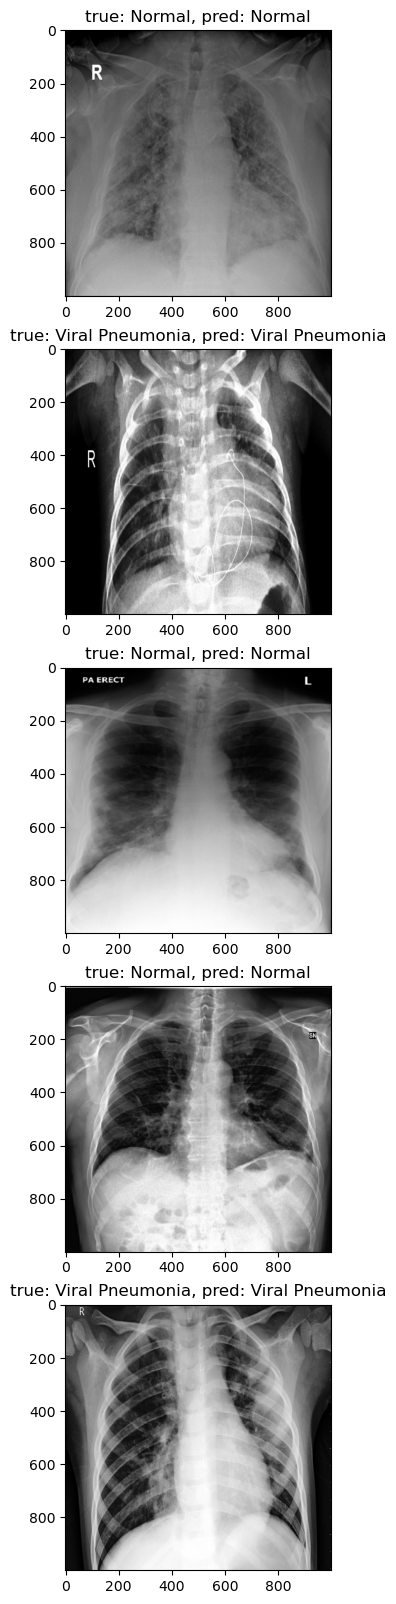

In [12]:
plt.figure(figsize=(10,20))

for i, j in enumerate(np.random.choice(np.arange(len(test_predictions)), 5)):
    plt.subplot(5,1,i+1)
    plt.imshow(test_images[j].astype(np.int32))
    plt.title(f'true: {LABELS[test_labels[j]]}, pred: {LABELS[test_predictions[j].argmax()]}')
plt.show()

Overall, the model is able to generalize well to the X-ray classification task. Looking at the validation loss (on the testing set) at each epoch during training, we see that the model was able to achieve a maximum accuracy of 0.9091. This is impressive because the number of training samples is quite low. Moreover, I found it difficult to classify the X-ray scans myself as a non-medical-expert, especially between instances of Normal and Viral Pneumonia. Thus, the model is able to identify features in the scans that would be challenging even for a human observer. 

Some directions of future work could be to:
- Analyze the effects of increasing training data on model performance to see how well the model could further generalize;
- Experiment with data augmentation techniques. For example, we could apply random crops, rotations, and perturbations to simulate additional data.